# Optimizing Wireless Router Placement #

### Table of Contents

1. [Introduction](#1.-Introduction)
1. [Mathematical Model](#2.-Mathematical-Model)
  1. [General Model Formulation](#2a.-General-Model-Formulation)
  1. [Modeling-Router-Range](#2b.-Modeling-Router-Range)
1. [Solution](#3.-Solution)
  1. [Random Target Matrix](#3a.-Random-Target-Matrix)
  1. [UW-Madison Campus Coverage](#3b.-UW-Madison-Campus-Coverage)
1. [Results and Discussion](#4.-Results-and-Discussion)
  1. [Solver Runtime](#4a.-Solver-Runtime)
1. [Conclusion](#5.-Conclusion)

## 1. Introduction

This report discusses optimizing router placement in a designated area to achieve full wireless coverage while minimizing cost in the form of routers and fiber-optic cable along with their respective installation.

Network coverage is a common issue faced on a large scale by telecommunications companies and university campuses as well as a smaller scale by the likes of offices, apartment complexes, and even individual households. Nearly all devices today either are able to connect wirelessly or require a wireless connection to access the internet. In order to provide all devices under the network with internet connectivity, access points must be able to be reached wirelessly from every location a device could reside.

For this reason, it is important for organizations to place wireless routers optimally to provide full coverage for users of their network while keeping costs of equipment and installation at a minimum. Generally, this will involve the use of a wireless mesh network (WMN), which consists of a singular router with a direct connection to the internet plus many other wireless nodes that communicate with the main router to extend the network. The objective of these nodes is to relay traffic to the main router so the devices connected to the network can have internet access.

Rather than having a main router and other wireless nodes, this solution uses an internet backbone - a switch to provide an internet connection to a router via ethernet - and multiple routers to provide a wireless access point to the internet in the network. Since the wireless nodes are replaced with hardwired routers, relaying traffic through a mesh is no longer a key concern. However, distance of the routers from the internet backbone now must be accounted for, as a longer distance requires more fiber-optic cable to be installed. One advantage of approaching the problem in this way where distance is considered is it provides a more similar configuration to other "coverage" optimization problems such as optimally placing warehouses and distribution centers in a supply chain for the least amount of travel or placing hospitals in a city to reduce emergency response time.

To create a general model for router placement, it is necessary to look at cases where areas that require coverage and the location of the internet backbone are randomly generated. Cost and range of the routers and cost of cable installation will be roughly estimated on typical current costs and commercial router strength. The complexity of the problem will also be touched on, primarily concerning the time it takes a solver to find an optimal solution.

## 2. Mathematical Model

### 2a. General Model Formulation

$\textbf{Problem Setup}$  
A grid $X$ with $m$ rows and $n$ columns containing cells of binary values must first be initialized as the problem area. Every $0$ represents an area that does not need coverage, while every $1$ represents an area that requires coverage. The grid will be set according to the layout of the proposed target network area. There must be at least a single cell with a $1$, but it is possible for the grid to contain all cells with $1$s (total target coverage). In this example, random binary values are assigned to each cell.

A single cell will also be chosen as the Internet backbone cell, $B$. This cell represents the location of the modem or switch that the routers can establish a wired connection to in order to access the internet, which again should be set according to the plan or limitations of the network area in question. In this example, the location of the backbone is randomly assigned.

Next, a maximum number of routers, $N$, to be used in the problem should be fixed. This should be set so as to never exceed the maximum number of routers to provide full coverage. This number will change based on the grid size and router range, so a best judgment should be made. This number will affect the amount of variables in the model, so it is wise not to set it arbitrarily high. The maximum router number is set to $10$. It is important to note that this is the absolute maximum number of routers allowed in the model, but oftentimes, the optimal solution may use less routers.

After this, a cost vector, $c_a$, and range vector, $r_a$, must be chosen based on the cost and range of the different available routers. The vectors must be equal in length (cost $a$ corresponds to router with range $a$) but may be any length greater than $0$. The length of the vectors will be called $R$. The range represents how many adjacent squares away from the router's square the wireless signal will reach (this includes up to $8$ squares). The router is placed at the center of a $1$x$1$ square, and so the range could be thought of as $r+0.5$ in the right, left, up and down directions. Therefore, a router with range $0$ still covers the single square in which the router is placed. Each grid square is modeled as $1$x$1$, but this could be scaled for larger applications such as a square representing a $100$ ft by $100$ ft area. For this model, the ranges must be integer values. The cost of the router includes both the equipment and installation cost.

Finally, a fixed cost for the cable connecting a router to the backbone, $w$, is chosen based on the cost of the actual cable and its installation for one square's width of cable. The distance from the router to the backbone is calculated as a Manhattan distance, which follows the formula $|x_1-x_2| + |y_1-y_2|$. Like the range before, this will vary based on the actual size each square represents.

To solve the problem, a new binary grid will be created for each router in use, where $1$s represent the cells that router is covering. With all $1$s in the new grids combined, every cell that had a $1$ in the initial grid $X$ will be covered for a feasible solution.

$\textbf{Objective}$  
The objective of this problem is to minimize the cost of the routers and cables used to cover the network. 

$\textbf{Decision Variables}$  
Binary variables will primarily be used to express if a router is being used or not. The variable $p_{ijak}$ is used to represent whether router $k$ out of the $N$ routers at row $i$, column $j$, with range $a$ is in use or not.

Another binary variable, $z_{ij}$, is used to represent if $[i,j]$ is within a router's range or not. These variables will be used to fill in $1$s to the new router grid. Variables $u$ and $v$ are used to represent the absolute value of the $x$ and $y$ distance, respectively, from each router to the backbone.

$\textbf{Constraints}$  
1. Every $1$ in the initial grid must be a $1$ in the new grid, so $X_{ij}$ must be less than or equal to $z_{ij}$.
2. Each cell within a router's range must be a $1$. This can be thought of differently by splitting it into two constraints:
    2a. If $z_{i,j} = 0$, then it cannot be in any router's range.
    2b. If $z_{i,j} = 1$, then it is within at least one router's range.
3. Each router $k$ can only be placed once on the new grid.
4. $u$ and $v$ must be at least $|B_1-j|$ and $|B_2-i|$, respectively. This captures the distance the cable connecting the router and backbone will run.

$\textbf{Model}$  
$$\begin{aligned}
    \text{minimize}\qquad& \sum_{k=1}^{N}\sum_{a=1}^{R}\sum_{j=1}^{n}\sum_{i=1}^{m}(c_{a}*p_{ijak}) 
        + w*\sum_{k=1}^{N}(u_{k}+v_{k}) \\
    \text{subject to}\qquad& X_{ij} \leq z_{ij} && \forall i \in 1, \dots, m, j \in 1, \dots, n \\
    & \sum_{i=1}^{m}\sum_{j=1}^{n}\sum_{\Delta i=-r_{a}}^{r_{a}}\sum_{\Delta j=-r_{a}}^{r_{a}}\sum_{k=1}^{N}\sum_{a=1}^{R}
        p_{(i+ \Delta i)(j+\Delta j)ak} \leq N*z_{ij} && \forall i \in 1, \dots, m, j \in 1, \dots, n \\
    & z_{ij} \leq \sum_{i=1}^{m}\sum_{j=1}^{n}\sum_{\Delta i=-r_{a}}^{r_{a}}\sum_{\Delta j=-r_{a}}^{r_{a}}\sum_{k=1}^{N}\sum_{a=1}^{R}
        p_{(i+\Delta i)(j+\Delta j)ak} && \forall i \in 1, \dots, m, j \in 1, \dots, n \\
    & \sum_{k=1}^{N}\sum_{a=1}^{R}\sum_{j=1}^{n}\sum_{i=1}^{m} p_{ijak} \leq 1 \\
    & u_{k} \geq \sum_{k=1}^{N}\sum_{a=1}^{R}\sum_{i=1}^{m}\sum_{j=1}^{n}p_{ijak}*(j-B_{2}) && 
    \forall k \in 1, \dots, N \\
    & u_{k} \geq \sum_{k=1}^{N}\sum_{a=1}^{R}\sum_{i=1}^{m}\sum_{j=1}^{n}p_{ijak}*(B_{1}-j) && 
    \forall k \in 1, \dots, N \\
    & v_{k} \geq \sum_{k=1}^{N}\sum_{a=1}^{R}\sum_{i=1}^{m}\sum_{j=1}^{n}p_{ijak}*(i-B_{2}) && 
    \forall k \in 1, \dots, N \\
    & v_{k} \geq \sum_{k=1}^{N}\sum_{a=1}^{R}\sum_{i=1}^{m}\sum_{j=1}^{n}p_{ijak}*(B_{2}-i) && 
    \forall k \in 1, \dots, N \\
    & p_{ijak}, z_{ij} \in \{0,1\} && \forall i \in 1, \dots, m, j \in 1, \dots, n, a \in 1, \dots, R, k \in 1, \dots, N \\
    & u_{k}, v_{k} \geq 0 && \forall k \in 1, \dots, N \\
  \end{aligned}$$

$\textbf{Assumptions}$  
A common issue with routers comes from interference, generally from other structures such as walls, ceilings, or entire buildings depending on the situation. What will usually happen when the wireless signal is interfered with is a lessening of the router's signal strength, meaning it will cover a smaller radius beyond the direction of the interfering object(s). In this problem, it is assumed there is no significant interference to reduce the router's range. For indoor routers, walls tend to be the largest source of interference. In this type of problem, walls could be accounted for in one of two ways: first, when a wall is reached by the signal, the signal simply stops in that direction; second, the signal would not stop but decrease in the direction of the wall based on the thickness and material of that wall. Adding this to the code to get a realistic estimate of the amount of interference walls cause would be very difficult. If it is needed for walls to be implemented in the initial grid, consider forming artificial "walls" by placing more $0$s where the walls would be in the network area.


### 2b. Modeling Router Range

$\textbf{Circular vs. Square}$  
Another important consideration was modeling the router ranges. Typically, routers are depicted using circular ranges with a uniform radius extending from the router, which seems contradictory to the model which depicts router coverage using a square grid. It turns out that routers with circular ranges can also be modeled using square router ranges if the parameters are chosen wisely. 

The radius of the circle must be chosen so that it covers the same number of squares as when using a square router range. To do this, the radius must be the diagonal from the central router to a corner of the covered square. According to the conventions in this model, for a router with a square range of $r$, the radius of the circular range must be $sqrt(((r+0.5)/2)^2+((r+0.5)/2)^2)$. This is simply the equation to find the Euclidean distance between two points, namely the router location to the corner of the square router range. Note that the $0.5$ is added because the router is located at the center of the square and a range of $0$ actually covers a $1$x$1$ square ($0.5$ in each direction). In addition, it might seem odd to choose a radius to match the grid, especially considering that the range of a router is a fixed parameter, but this is done out of convenience. The same model could be accomplished by adjusting the size of the grid instead.

Below is an example demonstrating the how square and circle router ranges can cover the exact same grid squares. The plots show $9$ routers with a range of $1$ in a $9$x$9$ grid for both square and circle ranges. These plots were created using functions similar to plotSquare and plotCircle functions that appear in later sections. It is clear that the $9$ routers can provide the same total coverage to the desired grid. The circle ranges have some added overlap and some range extending outside of the target grid, but coverage is not compounded$-$ a grid square is either covered or not covered. In addition, the model only counts coverage in squares that are completely covered, and so the grid squares outside the target that are partially covered on the right plot are not considered covered. Therefore, these two plots cover the exact same area. It is very practical to model the router ranges as grid squares without losing any meaning in the model. 

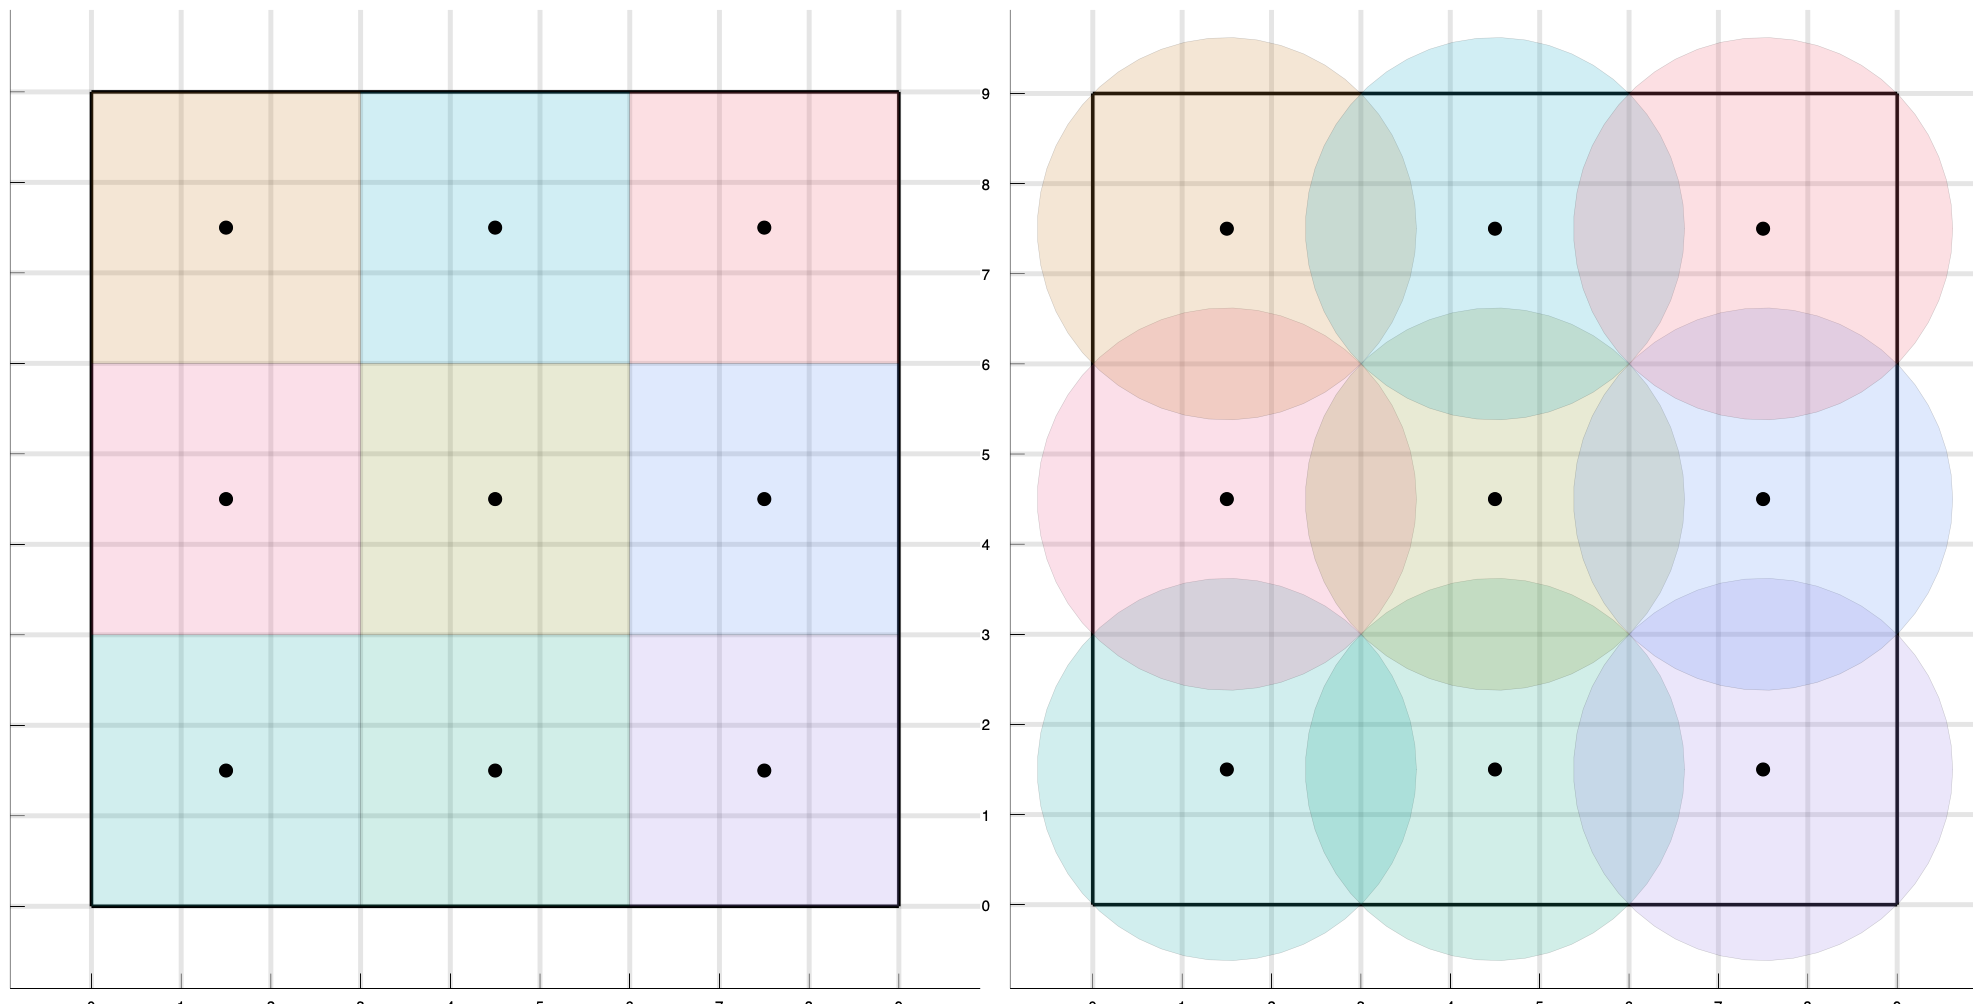

## 3. Solution
### 3a. Random Target Matrix

The main idea of this code is using a binary variable array `p[1:Lr, 1:Lc, 1:length(r), 1:N]` which represents the placement of a router. `Lr` is "length rows" and represents the number of rows and `Lc` the same for columns. The input array `r` is a list of possible router ranges. `N` is the maximum number of routers that are used. If `p[i, j, r[a], k] == 1`, this means that the $k$<sup>th</sup> router is being used at position $(i, j)$ and is using a range given by the $a$<sup>th</sup> element of `r`. So if `p[3, 3, r[1], 7] == 1` and `r = [2, 4, 5]` this means that the 7th router is located at $(3,3)$ and has a range of $2$.

The partner to the binary variable array `p` is the binary variable array `z[1:Lr, 1:Lc]`, which keeps track of which cells are covered or not. If `z[i, j] == 1` then the cell $(i,j)$ is within the range of some router. Likewise, if `z[i, j] == 0` then the cell is within range of any router.

Our distance variables are `u[1:N]` and `v[1:N]`. If the 3<sup>rd</sup> router is 1 unit up and 2 units to the left of the backbone, then `u[3] == 2` and `v[3] == 1`. Since these are distances, they are always positive.

Next, is the input array `X` representing which cells need coverage. If `X[i, j] == 1` the cell $(i,j)$ must be within the range of some router in the solution. If 0, it may or may not. So it is necessary to model the logical constraint "If `X[i,j] == 1`, then `z[i,j] == 1`". This is modeled as `X[i, j] <= z[i, j]` for all $i$ and $j$ in the code.

Now it is necessary to model the logical constraint "If `z[i, j] == 0` for some i, j then `p[i+di, j+di, a, k] == 0` for all `a` and `k` and for all appropriate `di` and `dj`. In words, this means that if a cell $(i,j)$ is not covered, then there is no router within `di` and `dj` of the cell. "Appropriate" `di` and `dj` means within the router's range and within the borders of the grid. These values are computed by the helper functions `get_di(i, j, Lr, Lc, r)` and `get_dj(i, j, Lr, Lc, r)`. If the problem has 1 router and that router has range 1, then `z[i,j] == 0` means that the router is not located within the 3x3 square bounded between $i-1$ and $i+1$ and $j-1$ and $j+1$. This logical constraint is modeled by `sum(sum(sum(sum(p[i+di, j+dj, a, k] for dj=get_dj(i, j, Lr, Lc, r[a])) for di=get_di(i, j, Lr, Lc, r[a])) for a=1:length(r)) for k=1:N) <= N*z[i, j]`

This logical constraint also needs the other direction, i.e. "If `z[i,j] == 1` for some i, j then `p[i+di, j+di, a, k] == 1` for some `a` and `k` and for some appropriate `di` and `dj`. In words, this means that if a cell $(i,j)$ is covered, then there is a router within `di` and `dj` of the cell. For example, taking the example again of 1 router with range 1, then `z[i,j] == 1` means that the router is located somewhere in that 3x3 square surrounding the cell. This logical constraint is modeled by `z[i, j] <= sum(sum(sum(sum(p[i+di, j+dj, a, k] for dj = get_dj(i, j, Lr, Lc, r[a])) for di=get_di(i, j, Lr, Lc, r[a])) for a=1:length(r)) for k=1:N)`

The next constraint in the code simply says that each router will have at most 1 place on the grid.

Next are the distance constraints. These say that `u` and `v` must have values of at least the distance from the cell to the backbone. Since the objective is trying to minimize these, this means that `u` and `v` will hold the x-distance and y-distance values from each cell to the backbone. Notice the L1 metric is being used here, also called "Manhattan" distance or the "Taxicab" metric. 

For the objective, there are 2 parts. The cost of the routers and the cost of the distance of cable. To get the cost of the routers, the sum is taken over all of the entries of `p`. If there is an entry `p[i, j, a, k] == 1` then that entry is multipled by the $a$<sup>th</sup> element of the input cost array `c`. If `c[a] == 50`, then that element of the sum will be `50`. For the cost of the cable, the sum `u[k] + v[k]` is taken over all `k` routers and multiplied by the input value `w` which is the weight of each unit of cable.

Minimizing this cost returns the most cost-efficient solution of router locations that still covers all necessary points given by `X`.

In [10]:
using JuMP, Cbc, Plots, Gurobi#, Mosek

function minRouterProblem(X, N, r, B, c, w)
    
    Lr = size(X)[1]      # number of rows
    Lc = size(X)[2]      # number of columns
    
    # X is marker grid, Lr is grid rows, Lc is grid columns, N is max num of routers, r is router range
    
    # m = Model(solver=CbcSolver())
     m = Model(solver=GurobiSolver(OutputFlag=0))
    # m = Model(solver=MosekSolver(LOG=0))
    
    @variable(m, p[1:Lr, 1:Lc, 1:length(r), 1:N], Bin) # p[i, j, r[a], k] = 1 if router k is at position i, j with range r[a].
                                                       # 0 otherwise
    @variable(m, z[1:Lr, 1:Lc], Bin)      # z[i, j] = 1 if it is within router range of i, j. 0 otherwise
    @variable(m, u[1:N] >= 0)  # absolute value variable for x values of distance from router to backbone
    @variable(m, v[1:N] >= 0)  # absolute value variable for y values of distance from router to backbone
    
    
    # marker constraints
    for i=1:Lr
        for j=1:Lc
            @constraint(m, X[i, j] <= z[i, j]) # if X[i, j] = 1, then z[i, j] = 1
            # if X[i, j] = 0, then it doesn't matter if the router hits this spot, therefore z[i,j] can be 0 or 1
        end
    end
    

    for i=1:Lr
        for j=1:Lc
            #first constraint says that if z[i,j]=0 then there are no routers nearby.
            @constraint(m, sum(sum(sum(sum(p[i+di, j+dj, a, k] for dj=get_dj(i, j, Lr, Lc, r[a])) 
                        for di=get_di(i, j, Lr, Lc, r[a])) for a=1:length(r)) for k=1:N) <= N*z[i, j])

            #second constraint says that if z[i,j]=1 then the num of routers nearby is >= 1
            @constraint(m, z[i, j] <= sum(sum(sum(sum(p[i+di, j+dj, a, k] for dj = get_dj(i, j, Lr, Lc, r[a])) 
                        for di=get_di(i, j, Lr, Lc, r[a])) for a=1:length(r)) for k=1:N))
                                            
        end
    end

    for k=1:N
        # each router k can have at most one place on the grid
        @constraint(m, sum(sum(sum(p[i, j, a, k] for i=1:Lr) for j=1:Lc) for a=1:length(r)) <= 1)
        
        for a=1:length(r)
            for i=1:Lr
                for j=1:Lc
                    # absolute value constraints for distance from router to nearest backbone
                    # B[1] corresponds to column j, B[2] corresponds to row i
                    @constraint(m, u[k] >= p[i, j, a, k]*(j-B[1]))
                    @constraint(m, u[k] >= p[i, j, a, k]*(B[1]-j))
                    @constraint(m, v[k] >= p[i, j, a, k]*(i-B[2]))
                    @constraint(m, v[k] >= p[i, j, a, k]*(B[2]-i))
                end
            end
        end
    end             
                                    
    # minimize the cost of routers and cable
    @objective(m, Min, sum(sum(sum(sum(c[a]*p[i, j, a, k] for i=1:Lr) for j=1:Lc) for a=1:length(r)) for k=1:N)
                            + w*sum(u[k]+v[k] for k=1:N))

    @time(status = solve(m))
    println(status)

    popt = getvalue(p)
    zopt = getvalue(z)
    
    total_routers = 0
    
    for k=1:N
        for a=1:length(r)
            if sum(sum(popt[i, j, a, k] for i=1:size(X)[1]) for j=1:size(X)[2] ) != 0 
                total_routers += 1
            end
        end
    end

    show_results(X, N, popt, zopt, total_routers, c, B, w, m)
    
    #To print graphically, choose plotSqaure or plotCircle
    #Note that if both are uncommented, only the second will print
    plotSquare(X, N, total_routers, r, popt, B)
#     plotCircle(X, N, total_routers, r, popt, B)

end

minRouterProblem (generic function with 1 method)

In [2]:
#prints the matrices with the results from the optimization
function show_results(X, N, popt, zopt, total_routers, c, B, w, m)
    
    Lr = size(X)[1]      # number of rows
    Lc = size(X)[2]      # number of columns
    
    router_cost = 0
    x_cable = 0
    y_cable = 0
    router_on_backbone = false
    
    println()
    # print marker grid
    println("marker locations:")
    for i=0:Lr-1
        println(X[Lr-i, :])
    end
    println()

    for k=1:N
        for a=1:length(r)
            if sum(sum(popt[i, j, a, k] for i=1:Lr) for j=1:Lc) != 0 # if router k is used, print it
                println("router ", k, ", radius ", r[a], ":")
                for i=0:Lr-1
                    println(popt[Lr-i, :, a, k])
                end
                println()
            end
        end
    end
    
    # compute router costs and cable costs manually to confirm that they match with the model results
    for k=1:N, a=1:length(r), i=1:size(X)[1], j=1:size(X)[2]
        if popt[i, j, a, k] == 1
            if i == B[2] && j == B[1]
                router_on_backbone = true
            end
            router_cost += c[a]
            x_cable += abs(B[2] - i)
            y_cable += abs(B[1] - j)
        end
    end


    println("covered spots:")
    for i=0:Lr-1
        println(zopt[Lr-i, :])
    end
    
    cable_cost = w*(x_cable + y_cable)
    
    println()
    println("Number of routers used = ", total_routers)
    println("Sum of router cost = \$", router_cost)
    println("Is there a router on top of the backbone? ", router_on_backbone ? "Yes." : "No.")
    println()
    println("Sum of cable cost = \$", cable_cost)
    println("Minimum total cost = \$", getobjectivevalue(m))
    println()

end

show_results (generic function with 1 method)

In [3]:
# this function gets index span in the vertical i direction
function get_di(i, j, Lr, Lc, r)
    
    d_up = 0
    done = false
    while done == false
        if d_up >= r               # stay within range
            done = true
        elseif i - d_up <= 1       # stay within top border
            done = true
        elseif done == false       # go to next cell above
            d_up += 1
        end
    end
    
    d_down = 0
    done = false
    while done == false
        if d_down >= r
            done = true
        elseif i + d_down >= Lr
            done = true
        elseif done == false
            d_down += 1
        end
    end
    
    return -d_up:d_down
end

# this gets index span in horizontal j direction.
function get_dj(i, j, Lr, Lc, r)
    
    d_left = 0
    done = false
    while done == false
        if d_left >= r
            done = true
        elseif j - d_left <= 1
            done = true
        elseif done == false
            d_left += 1
        end
    end
    
    d_right = 0
    done = false
    while done == false 
        if d_right >= r
            done = true
        elseif j + d_right >= Lc
            done = true
        elseif done == false
            d_right += 1
        end
    end
    
    return -d_left:d_right
end

get_dj (generic function with 1 method)

In [4]:
#This method plots the optimization results using square router ranges
function plotSquare(X, N, total_routers, r, popt, B)
    target_width = size(X)[1]      # number of rows
    target_length = size(X)[2]      # number of columns
    x_loc = Array{Float64}(1, total_routers) 
    y_loc = Array{Float64}(1, total_routers)
    range = Array{Float64}(1, total_routers)
    Bx_loc = Array{Float64}(1, 1)
    By_loc = Array{Float64}(1, 1)
    
    Bx_loc[1] = B[1]
    By_loc[1] = B[2]
    
    num_flags = 0    # number of cells in X that are 1, i.e. those that need coverage
    for i=1:size(X)[1]
        for j=1:size(X)[2]
            if X[i, j] == 1
                num_flags += 1
            end
        end
    end
    
    xf_loc = Array{Float64}(1, num_flags)
    yf_loc = Array{Float64}(1, num_flags)
    
    idx1 = 1
    idx2 = 1
    for k in 1:N
        for a in 1:length(r)
            for i in 1:target_width
                for j in 1:target_length
                    if popt[i, j, a, k] == 1
                        x_loc[idx1] = j - 0.5
                        y_loc[idx1] = i - 0.5
                        range[idx1] = r[a]
                        idx1 += 1
                    end
                    if idx2 <= num_flags
                        if X[i, j] == 1
                            xf_loc[idx2] = j - 0.5
                            yf_loc[idx2] = i - 0.5
                            idx2 += 1
                        end
                    end
                end
            end
        end
    end

    for i in 1:length(range)
        range[i] = 2*range[i] + 1
    end
    ratio = target_width/target_length
    rectangle(w, h, x, y) = Shape(x + [0,w,w,0], y + [0,0,h,h])

    x_sq = Array{Float64}(1, length(x_loc))
    y_sq = Array{Float64}(1, length(x_loc))

    for i in 1:length(x_loc)
        x_sq[i] = (x_loc[i] - (range[i]/2))
        y_sq[i] = (y_loc[i] - (range[i]/2))
    end

    l_size = collect(0:1:target_length)
    l_zeros = zeros(target_length+1)
    l_max = fill(target_width,target_length+1)
    w_size = collect(0:1:target_width)
    w_zeros = zeros(target_width+1)
    w_max = fill(target_length,target_width+1)

    plot(rectangle(target_length,target_width,0,0), opacity = 0, size=(2000,2000*ratio), 
            xticks = 0:1:target_length, yticks = 0:1:target_width, gridlinewidth=10, tickfontsize=20, legend=false)
    
    plot!(l_size, l_zeros, linewidth=7, linecolor=:black)
    plot!(w_zeros, w_size, linewidth=7, linecolor=:black)
    plot!(l_size, l_max, linewidth=7, linecolor=:black)
    plot!(w_max, w_size, linewidth=7, linecolor=:black)
    
    for i in 1:length(x_loc)
        plot!(rectangle(range[i], range[i], x_sq[i], y_sq[i]), opacity = .2)
    end

    plot!(xf_loc, yf_loc, seriestype=:scatter, markersize=20, markercolor=:red) # checkpoints/ targets
    plot!(x_loc, y_loc, seriestype=:scatter, markersize=20, markercolor=:black)    # routers
    plot!(Bx_loc-.5, By_loc-.5, seriestype=:scatter, markersize=20, markercolor=:blue)  # backbone
    
end

plotSquare (generic function with 1 method)

In [5]:
#This method plots the optimization results using circle router ranges
function plotCircle(X, N, total_routers, r, popt, B)
    rectangle(w, h, x, y) = Shape(x + [0,w,w,0], y + [0,0,h,h])
    target_width = size(X)[1]      # number of rows
    target_length = size(X)[2]      # number of columns
    x_loc = Array{Float64}(1, total_routers) 
    y_loc = Array{Float64}(1, total_routers)
    range = Array{Float64}(1, total_routers)
    Bx_loc = Array{Float64}(1, 1)
    By_loc = Array{Float64}(1, 1)
    
    Bx_loc[1] = B[1] - 0.5
    By_loc[1] = B[2] - 0.5

    num_flags = 0    # nymber of cells in X that are 1, i.e. those that need coverage
    for i=1:size(X)[1]
        for j=1:size(X)[2]
            if X[i, j] == 1
                num_flags += 1
            end
        end
    end
    
    xf_loc = Array{Float64}(1, num_flags)
    yf_loc = Array{Float64}(1, num_flags)
    
    idx1 = 1
    idx2 = 1
    for k in 1:N
        for a in 1:length(r)
            for i in 1:target_width
                for j in 1:target_length
                    if popt[i, j, a, k] == 1
                        x_loc[idx1] = j - 0.5
                        y_loc[idx1] = i - 0.5
                        range[idx1] = r[a]
                        idx1 += 1
                    end
                    if idx2 <= num_flags
                        if X[i, j] == 1
                            xf_loc[idx2] = j - 0.5
                            yf_loc[idx2] = i - 0.5
                            idx2 += 1
                        end
                    end
                end
            end
        end
    end

    for i in 1:length(range)
        range[i] = 2*range[i] + 1
    end
    ratio = target_width/target_length
    for i in 1:length(range)
        range[i] = sqrt((range[i]/2)^2 + (range[i]/2)^2)
    end

    l_size = collect(0:1:target_length)
    l_zeros = zeros(target_length+1)
    l_max = fill(target_width,target_length+1)
    w_size = collect(0:1:target_width)
    w_zeros = zeros(target_width+1)
    w_max = fill(target_length,target_width+1)

    plot(rectangle(target_length,target_width,0,0), opacity = 0, size=(2000,2000*ratio), 
            xticks = 0:1:target_length, yticks = 0:1:target_width, gridlinewidth=10, tickfontsize=20, legend=false)

    plot!(l_size, l_zeros, linewidth=7, linecolor=:black)
    plot!(w_zeros, w_size, linewidth=7, linecolor=:black)
    plot!(l_size, l_max, linewidth=7, linecolor=:black)
    plot!(w_max, w_size, linewidth=7, linecolor=:black)

    for j in 1:length(range)
        curr= Plots.partialcircle(0, 2*3.1415, 50, range[j])
        circ = Array{Tuple{Float64,Float64}}(length(curr))

        for i in 1:length(curr)
            circ[i] = tuple(curr[i][1] + x_loc[j], curr[i][2] + y_loc[j])
        end
        plot!(Shape(circ), opacity = .2)
    end

    plot!(xf_loc, yf_loc, seriestype=:scatter, markersize=20, markercolor=:red) # checkpoints/ targets
    plot!(x_loc, y_loc, seriestype=:scatter, markersize=20, markercolor=:black)    # routers
    plot!(Bx_loc-.5, By_loc-.5, seriestype=:scatter, markersize=20, markercolor=:blue) # backbone
end

plotCircle (generic function with 1 method)

In [6]:
#creates the random binary target matrix
function radomTargets(numRows, numColumns)
    X = zeros(numRows, numColumns)
    
    for i in 1:numRows
        rdTF = bitrand(RandomDevice(), numColumns)
        rd = Array{Int64}(1, numColumns)
        for j in 1:numColumns
            if rdTF[j] == true
                rd[j] = 1
            end
            if rdTF[j] == false
                rd[j] = 0
            end
            X[i,j] = rd[j]
        end
    end

    return X
end

radomTargets (generic function with 1 method)

Academic license - for non-commercial use only
 52.419001 seconds (169 allocations: 17.568 MiB, 0.03% gc time)
Optimal

marker locations:
[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0]
[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0]
[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0]
[0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0]
[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0]
[1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0]
[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0]

router 3, radius 1:
[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]
[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0]
[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]
[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]
[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]
[-0.0, -0.0, -0.0, -0.0, -0

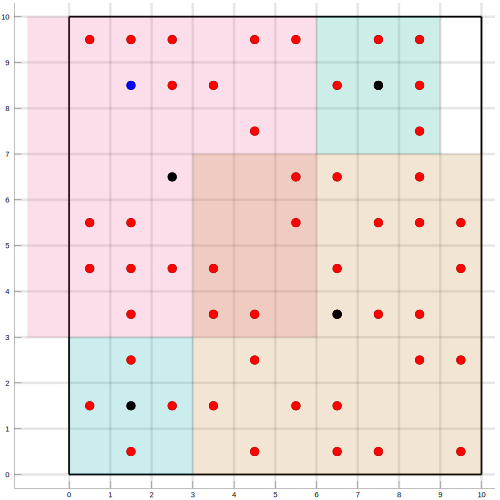

In [12]:
##This code block sets the parameters, calls the other functions, and kicks of the optiization

N = 10   # max number of routers
r = [1, 2, 3]   # range
X = radomTargets(10, 10)
# print(X)

Lr = size(X)[1] # grid rows
Lc = size(X)[2] # grid columns

B = [ rand(1:Lr), rand(1:Lc) ] # initialize cells of backbone
c = [50, 100, 150]  # cost of routers with varying ranges
w = 5  # fixed cost of one square of cable installation connecting router to backbone

minRouterProblem(X, N, r, B, c, w)

Note that there are two plotting functions above, plotSquare and plotCircle, that plot the optimized solution using square or circle router ranges respectively. However, only one can be called at a time. If you want to switch which function is being called, you will have to switch which one in uncommented/commented out at the end of the minRouterProblem function.

### 3b. UW-Madison Campus Coverage
Here is an example using the model on the UW campus. It starts with a map of the campus, which extends $2.04$ miles east-west and $0.8$ miles north-south.

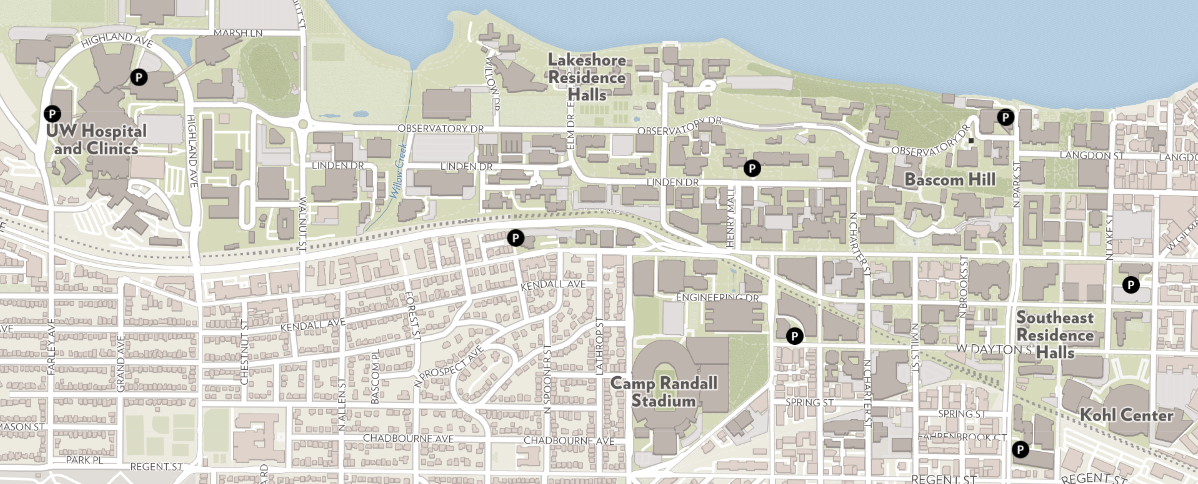

Now we'll overlay a $8$x$20$ grid on the map and put a $1$ in the cell if it contains a UW building and $0$ if it does not.

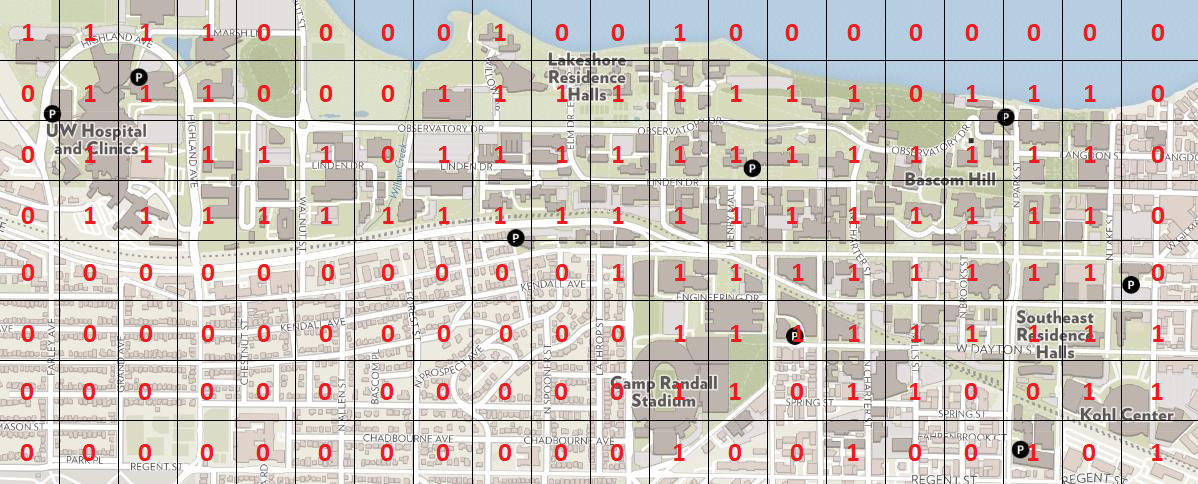

To make the model practical and specific to this example, it is necessary to make some assumptions. First we'll assume a limit on the number of routers used, since the IT unit probably doesn't want to manage too many locations. We'll set N=15 routers. We'll also set the backbone at a reasonable location, being $(x,y) = (12, 4)$, the cell including "Henry Mall" just northeast of the University Ave intersection. For reference, the lower left cell is $(0, 0)$. 

We'll then assume that all the routers have a range radius of $3$ city blocks, or $0.15$ miles. In this example, each cell is $0.1$ by $0.1$ miles. Also, we'll say that each router costs $\$1000$ dollars to buy and set up and each cell of cable costs $\$250$. Note that this is not real data.

Academic license - for non-commercial use only
114.531335 seconds (169 allocations: 7.801 MiB)
Optimal

marker locations:
[1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0]
[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0]

router 1, radius 1:
[-0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

router 10, radius 1:
[-0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[-0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0]
[0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0]
[0.0, 0.0, -0.0, 0.0, 0.0, 1.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0]
[0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0]

router 11, rad

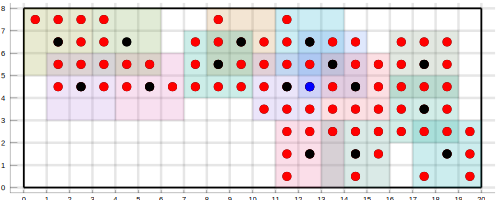

In [18]:
### CAUTION: This may take up to 5 minutes to run, depending on your machine.

N = 15   # max number of routers. The choice of 30 is arbitrary as the model surely won't need that many.

         # here it is assumed there are routers with range radius of about 3 city blocks, or 0.15 miles.
r = [1]  # this range coincides with a range of 1 square in the model.


# Here is the grid representation of the UW campus above.
Z = [1 1 1 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0;
     0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0;
     0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0;
     0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0;
     0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0;
     0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1;
     0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1 1;
     0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 1]
# But a matrix for the model requires that the bottom row is the 0 row. So it is necessary to vertically flip it
X = zeros(8, 20)

for i=1:8
    for j=1:20
        X[i, j] = Z[8 - i + 1, j]
    end
end
Lr = size(X)[1] # grid rows
Lc = size(X)[2] # grid columns

# We'll assume a reasonable position for the backbone, at position (12, 4). This is the cell containing "Henry Mall"
# adjusting to 1-indexing it becomes (13, 5).
B = [13, 5] # initialize cells of backbone
c = [1000]  # cost of routers with varying ranges
w = 250  # fixed cost of one square of cable installation connecting router to backbone

minRouterProblem(X, N, r, B, c, w)

Here is the graphical solution to the UW example. The blue dot is the backbone, the black dots are the routers, and the red dots are points that need to be covered.

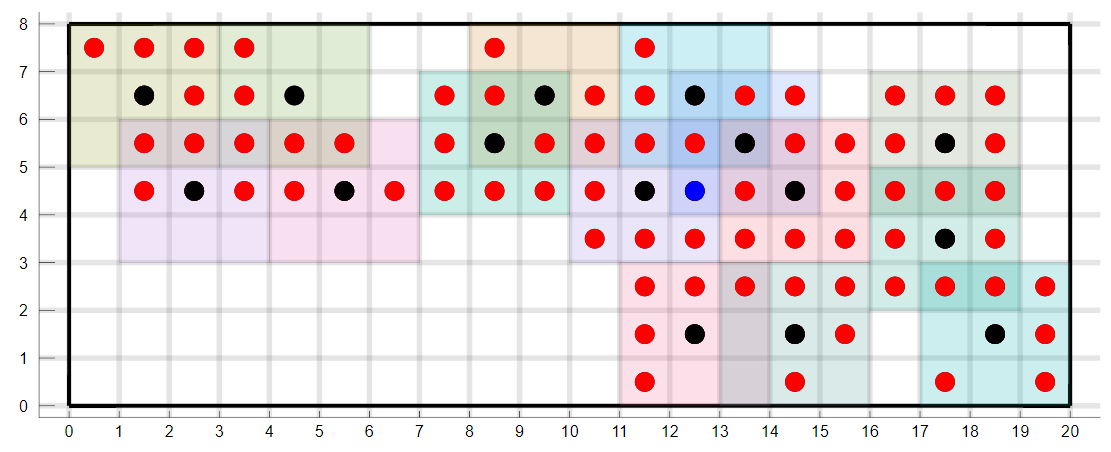

## 4. Results and Discussion

### 4a. Solver Runtime

Linear programming problems based on a grid space with binary variables tend to grow in complexity very fast as the grid grows larger. As we're observing a general case of the router placement problem, it is important to study the time it takes for a solver to find an optimal solution, especially when many decision variables are in play.

Through initial trial and error, it was found that for grids where squares that needed coverage were randomly generated, once the optimal solution required a certain number of routers (~$5$ in most cases), the solver would run for an unreasonable amount of time given the scope of the project. The cutoff limit for runtime was set at $10$ minutes - if no solution could be found in under $10$ minutes consistently for a given grid size for a set solver, then that solver's "limit" for the given model was set at one grid size below.

$3$ different solvers are considered for observing runtimes: Gurobi, Mosek, and Cbc. To visualize how grid size and the number of decision variables would affect the runtime, certain aspects of the model were fixed. The range array is set to be as small as possible but greater than ``0`` at ``r=[1,2,3]`` with a corresponding cost vector of ``c=[50,100,150]`` for a relative value of $\$50$ per 1 range. The cost for each square of cable installed is set to $\$5$ per square. The maximum number of routers is $10$. The backbone cell is randomized and each cell of the grid also has a $50$% chance of needing coverage. Each grid size tested is a square, starting with a $4$x$4$ grid and increasing by $1$ row and $1$ column for each size up until the solver cannot find an optimal solution fast enough. An average of $3$ trials for each grid size and each solver is reported in the following graphs and table.

Results were recorded manually based on the @time macro. All trials were run on a 2014 Lenovo Y40-70 laptop. It is important to note that runtimes will vary from machine to machine, but this will give a fair picture of general solver runtime for the problem on most devices.

Academic license - for non-commercial use only
  0.040522 seconds (146 allocations: 1.924 MiB)
Optimal

marker locations:
[0.0, 0.0, 0.0, 1.0]
[1.0, 0.0, 1.0, 1.0]
[0.0, 0.0, 1.0, 0.0]
[1.0, 1.0, 1.0, 0.0]

router 9, radius 2:
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 1.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]

covered spots:
[1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0]

Number of routers used = 1
Sum of router cost = $100
Is there a router on top of the backbone? No.

Sum of cable cost = $5
Minimum total cost = $105.0



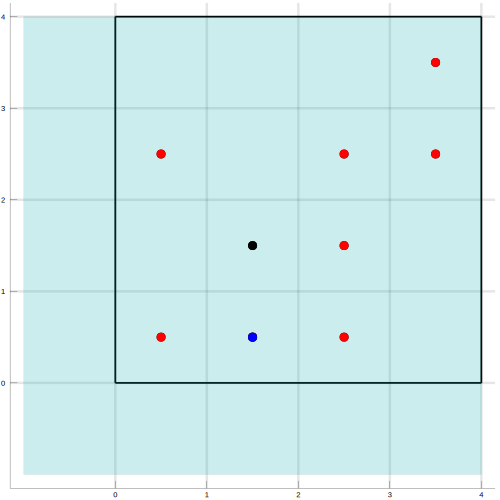

In [9]:
N = 10   # max number of routers
r = [1, 2, 3]   # range

# Change size of grid here to test different runtimes. Solver can be changed in the minRouterProblem function.
X = radomTargets(4, 4)

Lr = size(X)[1] # grid rows
Lc = size(X)[2] # grid columns

B = [ rand(1:Lr), rand(1:Lc) ] # initialize cells of backbone
c = [50, 100, 150]  # cost of routers with varying ranges
w = 5  # fixed cost of one square of cable installation connecting router to backbone

minRouterProblem(X, N, r, B, c, w)

In [14]:
# Runtime tests done with:
# N = 10
# r = [1, 2, 3]
# c = [50, 100, 150]
# w = 5
# plotSquare function
# random coverage cells and backbone
# no random seed set when generating grid - results will vary

GurobiTime = zeros(11,4)
MosekTime = zeros(11,4)
CbcTime = zeros(11,4)

# Runtime data was tracked and recorded manually on the same machine for each trial
# Each column is one trial, 4th column will be the average of the 3 trials
# Each row corresponds to one grid size, starting at 4x4 up to 14x14
GurobiTime = [ 0.170523 0.093677 0.064972 0
            0.180512 0.264644 0.233623 0
            0.373171 0.410605 0.389192 0
            0.481254 0.448536 0.439048 0
            17.806860 20.286144 1.620209 0
            46.256676 24.920865 39.603036 0
            35.858257 56.837292 90.940900 0
            102.438271 64.842598 170.629426 0
            183.279858 151.426716 76.230233 0
            262.065495 162.493657 79.094397 0
            136.357759 81.534443 190.136752 0 ]

MosekTime = [ 0.082701 0.111384 0.049622 0
        0.232193 0.255851 0.242969 0
        0.453398 0.414465 0.427702 0
        0.591096 0.477257 0.691197 0
        9.261104 2.564089 28.783665 0
        1.274036 17.422233 55.281318 0
        157.946115 399.390931 521.457209 0
        252.512818 333.976835 590.651503 0
        72.122866 81.720161 343.522679 0
        221.795092 135.618032 183.104460 0
        59.833514 27.056285 24.255692 0 ]

# Last 6 rows are zero due to Cbc Solver being unable to find an optimal solution in a reasonable time (under 10 mins)
# for those grid sizes.
CbcTime = [ 0.229500 0.381378 0.175482 0
        0.327200 0.291674 0.348367 0
        1.352916 1.160332 0.455638 0
        0.488609 0.603884 0.512348 0
        65.076971 71.478683 209.464408 0 
        0 0 0 0 
        0 0 0 0 
        0 0 0 0 
        0 0 0 0 
        0 0 0 0 
        0 0 0 0 ]

# get averages of 3 trials
for i=1:11
    GurobiTime[i,4] = sum(GurobiTime[i,1:3])/3
    MosekTime[i,4] = sum(MosekTime[i,1:3])/3
    CbcTime[i,4] = sum(CbcTime[i,1:3])/3
end

# Plot runtime values vs squares in grid
x = [ 4^2, 5^2, 6^2, 7^2, 8^2, 9^2, 10^2, 11^2, 12^2, 13^2, 14^2 ]
y=GurobiTime[:,4]
z=MosekTime[:,4]
w=CbcTime[:,4]
p = plot(x, y, title="Solver Runtime for Varying Grid Sizes", xlabel = "# of squares in grid", 
    ylabel="Average runtime (in seconds)", lw=3, label=["Gurobi" "Mosek" "Cbc"])
plot!(p, x, z, lw=3, label=["Mosek" "Cbc"])
plot!(p, x, w, lw=3, label=["Cbc"])
savefig("runtime-grid.png")

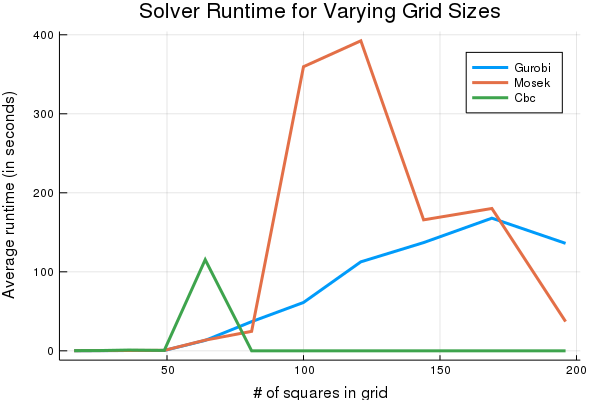

Note: The Cbc solver began failing to solve in a reasonable amount of time on the $9$x$9$ grid and thus does not have data for the following larger grid sizes. This is why the runtime appears as $0$ for Cbc on the graphs.

In [56]:
# Plot runtime values vs # of decision variables
x = [ 20+4^2+4^2*30, 20+5^2+5^2*30, 20+6^2+6^2*30, 20+7^2+7^2*30, 20+8^2+8^2*30, 20+9^2+9^2*30, 20+10^2+10^2*30, 20+11^2+11^2*30, 20+12^2+12^2*30, 20+13^2+13^2*30, 20+14^2+14^2*30 ]
p = plot(x, y, title="Solver Runtime for Varying Numbers of Decision Variables", xlabel = "# of decision variables", 
    ylabel="Average runtime (in seconds)", lw=3, label=["Gurobi" "Mosek" "Cbc"])
plot!(p, x, z, lw=3, label=["Mosek" "Cbc"])
plot!(p, x, w, lw=3, label=["Cbc"])
savefig("runtime-variable.png")

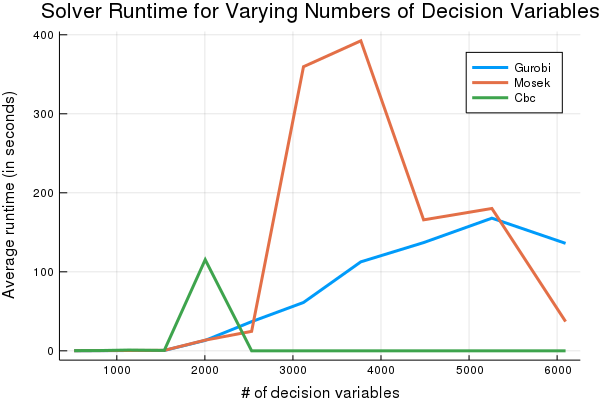

Note that the graphs are nearly identical. This is due to the size of the grid having a large influence on the amount of decision variables in the problem. The maximum number of routers can also greatly influence the number of decision variables, but was left as a static value for this example.

Notice that each line does not increase throughout. While this could likely be due to the low number of sample runs done, there were noticeable runtime improvements for certain solvers at certain grid sizes. Solutions for grids that could be covered completely with minimal overlap from the routers tended to have the lowest runtimes. Runtime may also vary quite a bit when the grid is not a square, as the router range can only be observed in a square area here. 

A maximum grid size of $14$x$14$ may seem rather small for large scale problems. However, without even considering the use of heuristics to find a feasible solution, this can be adjusted for in the setup of the grid and router ranges. The number of cells in a grid can be reduced by changing the area each cell represents to be a larger area. If loss of detail is not an option, the problem could still initially be reduced by letting each grid be a larger area, but then also solving subproblems consisting of another grid for each cell or group of cells in the initial grid.

It is also important to keep in mind that this grid limit is only for routers with ranges of $1$, $2$, and $3$. Using larger ranges will bring down the number of routers required to provide full coverage. Since the number of routers required tends to be a large contributor to runtime, larger grid sizes can be used (to an extent, as it still creates many more decision variables) as long as the number of routers required for coverage remains low.

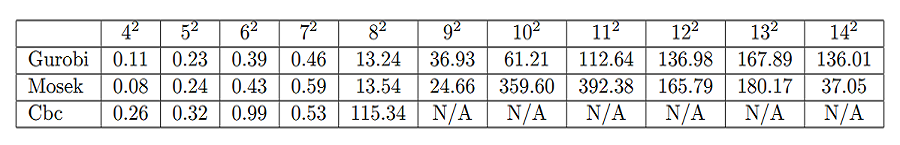

A table of columns for grid size and rows for solver shows numerically the averages in seconds for each runtime.

## 5. Conclusion

The model was able to optimize router placement over an $m$ by $n$ grid of moderate size while minimizing the cost of the routers and the fiber optics cable. The model ensured complete coverage of the target squares by adjusting the router locations and the router ranges. The cost was calculated based on the several distinct costs of the routers and the distance from the router to the backbone times a fixed cable cost per square. With all the variables in the model, the complexity and optimization time grew very rapidly as the model scaled. Through testing, it was determined that the run-time was more heavily influenced by the number of routers needed than other parameters such as grid size. When the problem required more than $5$ routers, the model often took an unreasonable amount of time to optimize for the given project. The different run times were compared for randomly generated target matrices using Gurobi, Mosek, and Cbc solvers. The Cbc solver was always the slowest, and could not handle grid sizes larger than $8$x$8$. Gurobi gave fastest optimization times for the majority of cases, but as the grid grew, Mosek began optimizing faster.

In the future, it would be useful to add the effects of various router interferences to the model. One important interference that would relate to the model set-up is the router's behavior in the presence of walls. This aspect could be added to the model but specifying the locations of walls in the target $X$ matrix. A wall could be represented using a different character, say a #, and then for other squares a $1$ would still be a square that needs coverage and a $0$ would be a square that does not need coverage. In real applications, a routers signal strength is typically reduce when it hit a wall, but the model has no way of represented partial or weak coverage. Instead, a router signal could stop when it hits a wall.

For future application, it is also important to recognize the generality of this model. It does not need to be constrained to only wireless network problems. For example, one could easily use this model to compute optimal locations of shipping centers given a central supply warehouse. The "routers" would be shipping centers, the "backbone" would be the supply warehouse, and the given marker locations would be delivery/transmission hotspots. The cost of cable would be replaced by travel time. Despite the different names, the actual model works the same.